# Classifying Water Potability (by Erfan SHEKARRIZ)

This project makes use of the WHO water quality data set that combines basic parameters measurable by instruments that can ultimate determine the potability of the water (a parameter utlimately nuanced by biological factors such as microbial growth and eutrophication degree). 

## Feature Exploration

In [115]:
# import data exploration libraries
import pandas as pd 
import numpy as np 
import missingno as msno

# implot plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot
import plotly.figure_factory as ff
from plotly.subplots import make_subplots 
import statsmodels.api as sm
from tqdm.notebook import tqdm


# import machine learning libraries
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



#### Feature Details (Provided by WHO)

1. pH value: PH is an important parameter in evaluating the acid–base balance of water. It is also the indicator of acidic or alkaline condition of water status. WHO has recommended maximum permissible limit of pH from 6.5 to 8.5. The current investigation ranges were 6.52–6.83 which are in the range of WHO standards.


2. Hardness: Hardness is mainly caused by calcium and magnesium salts. These salts are dissolved from geologic deposits through which water travels. The length of time water is in contact with hardness producing material helps determine how much hardness there is in raw water. Hardness was originally defined as the capacity of water to precipitate soap caused by Calcium and Magnesium.


3. Solids (Total dissolved solids - TDS): Water has the ability to dissolve a wide range of inorganic and some organic minerals or salts such as potassium, calcium, sodium, bicarbonates, chlorides, magnesium, sulfates etc. These minerals produced un-wanted taste and diluted color in appearance of water. This is the important parameter for the use of water. The water with high TDS value indicates that water is highly mineralized. Desirable limit for TDS is 500 mg/l and maximum limit is 1000 mg/l which prescribed for drinking purpose.


4. Chloramines: Chlorine and chloramine are the major disinfectants used in public water systems. Chloramines are most commonly formed when ammonia is added to chlorine to treat drinking water. Chlorine levels up to 4 milligrams per liter (mg/L or 4 parts per million (ppm)) are considered safe in drinking water.


5. Sulfate: Sulfates are naturally occurring substances that are found in minerals, soil, and rocks. They are present in ambient air, groundwater, plants, and food. The principal commercial use of sulfate is in the chemical industry. Sulfate concentration in seawater is about 2,700 milligrams per liter (mg/L). It ranges from 3 to 30 mg/L in most freshwater supplies, although much higher concentrations (1000 mg/L) are found in some geographic locations.


6. Conductivity: Pure water is not a good conductor of electric current rather’s a good insulator. Increase in ions concentration enhances the electrical conductivity of water. Generally, the amount of dissolved solids in water determines the electrical conductivity. Electrical conductivity (EC) actually measures the ionic process of a solution that enables it to transmit current. According to WHO standards, EC value should not exceeded 400 μS/cm.


7. Organic_carbon: Total Organic Carbon (TOC) in source waters comes from decaying natural organic matter (NOM) as well as synthetic sources. TOC is a measure of the total amount of carbon in organic compounds in pure water. According to US EPA < 2 mg/L as TOC in treated / drinking water, and < 4 mg/Lit in source water which is use for treatment.


8. Trihalomethanes: THMs are chemicals which may be found in water treated with chlorine. The concentration of THMs in drinking water varies according to the level of organic material in the water, the amount of chlorine required to treat the water, and the temperature of the water that is being treated. THM levels up to 80 ppm is considered safe in drinking water.


9. Turbidity: The turbidity of water depends on the quantity of solid matter present in the suspended state. It is a measure of light emitting properties of water and the test is used to indicate the quality of waste discharge with respect to colloidal matter. The mean turbidity value obtained for Wondo Genet Campus (0.98 NTU) is lower than the WHO recommended value of 5.00 NTU.




### Import Data

In [83]:
# read the path from path file & have a look at the datatypes 
path = '/Users/erfanshekarriz/git_repo/ML_miniprojects/waterquality_assesment/data/water_potability.csv'
df_raw = pd.read_csv(path)

# summary data
df_raw.info()
df_raw.describe()

# change Potability into a category 
df_raw.Potability = df_raw.Potability.astype('category')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


### Univariate Analysis

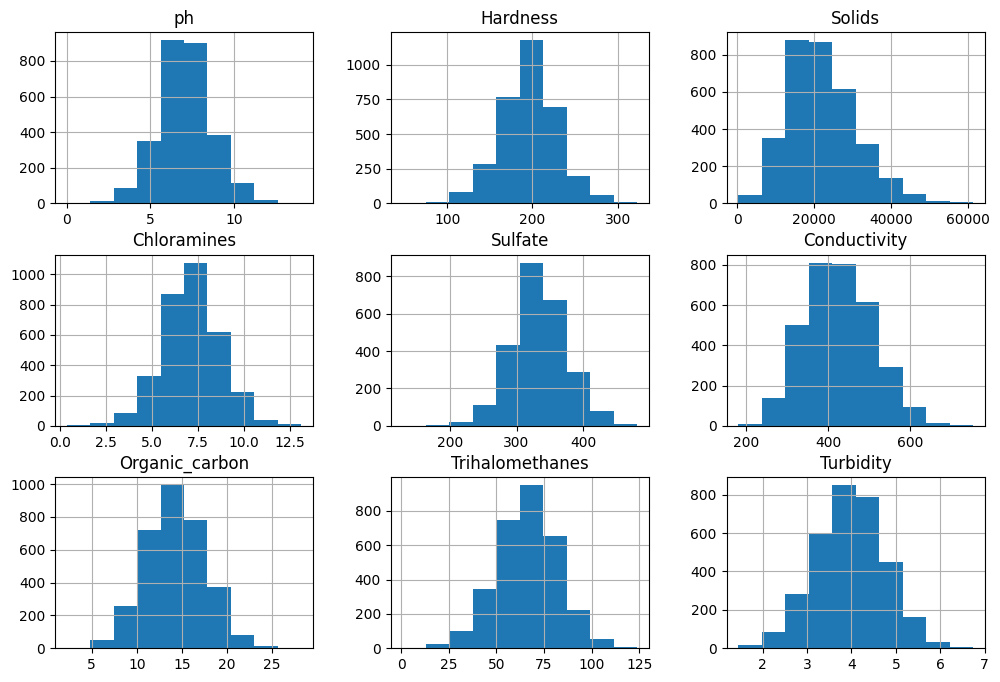

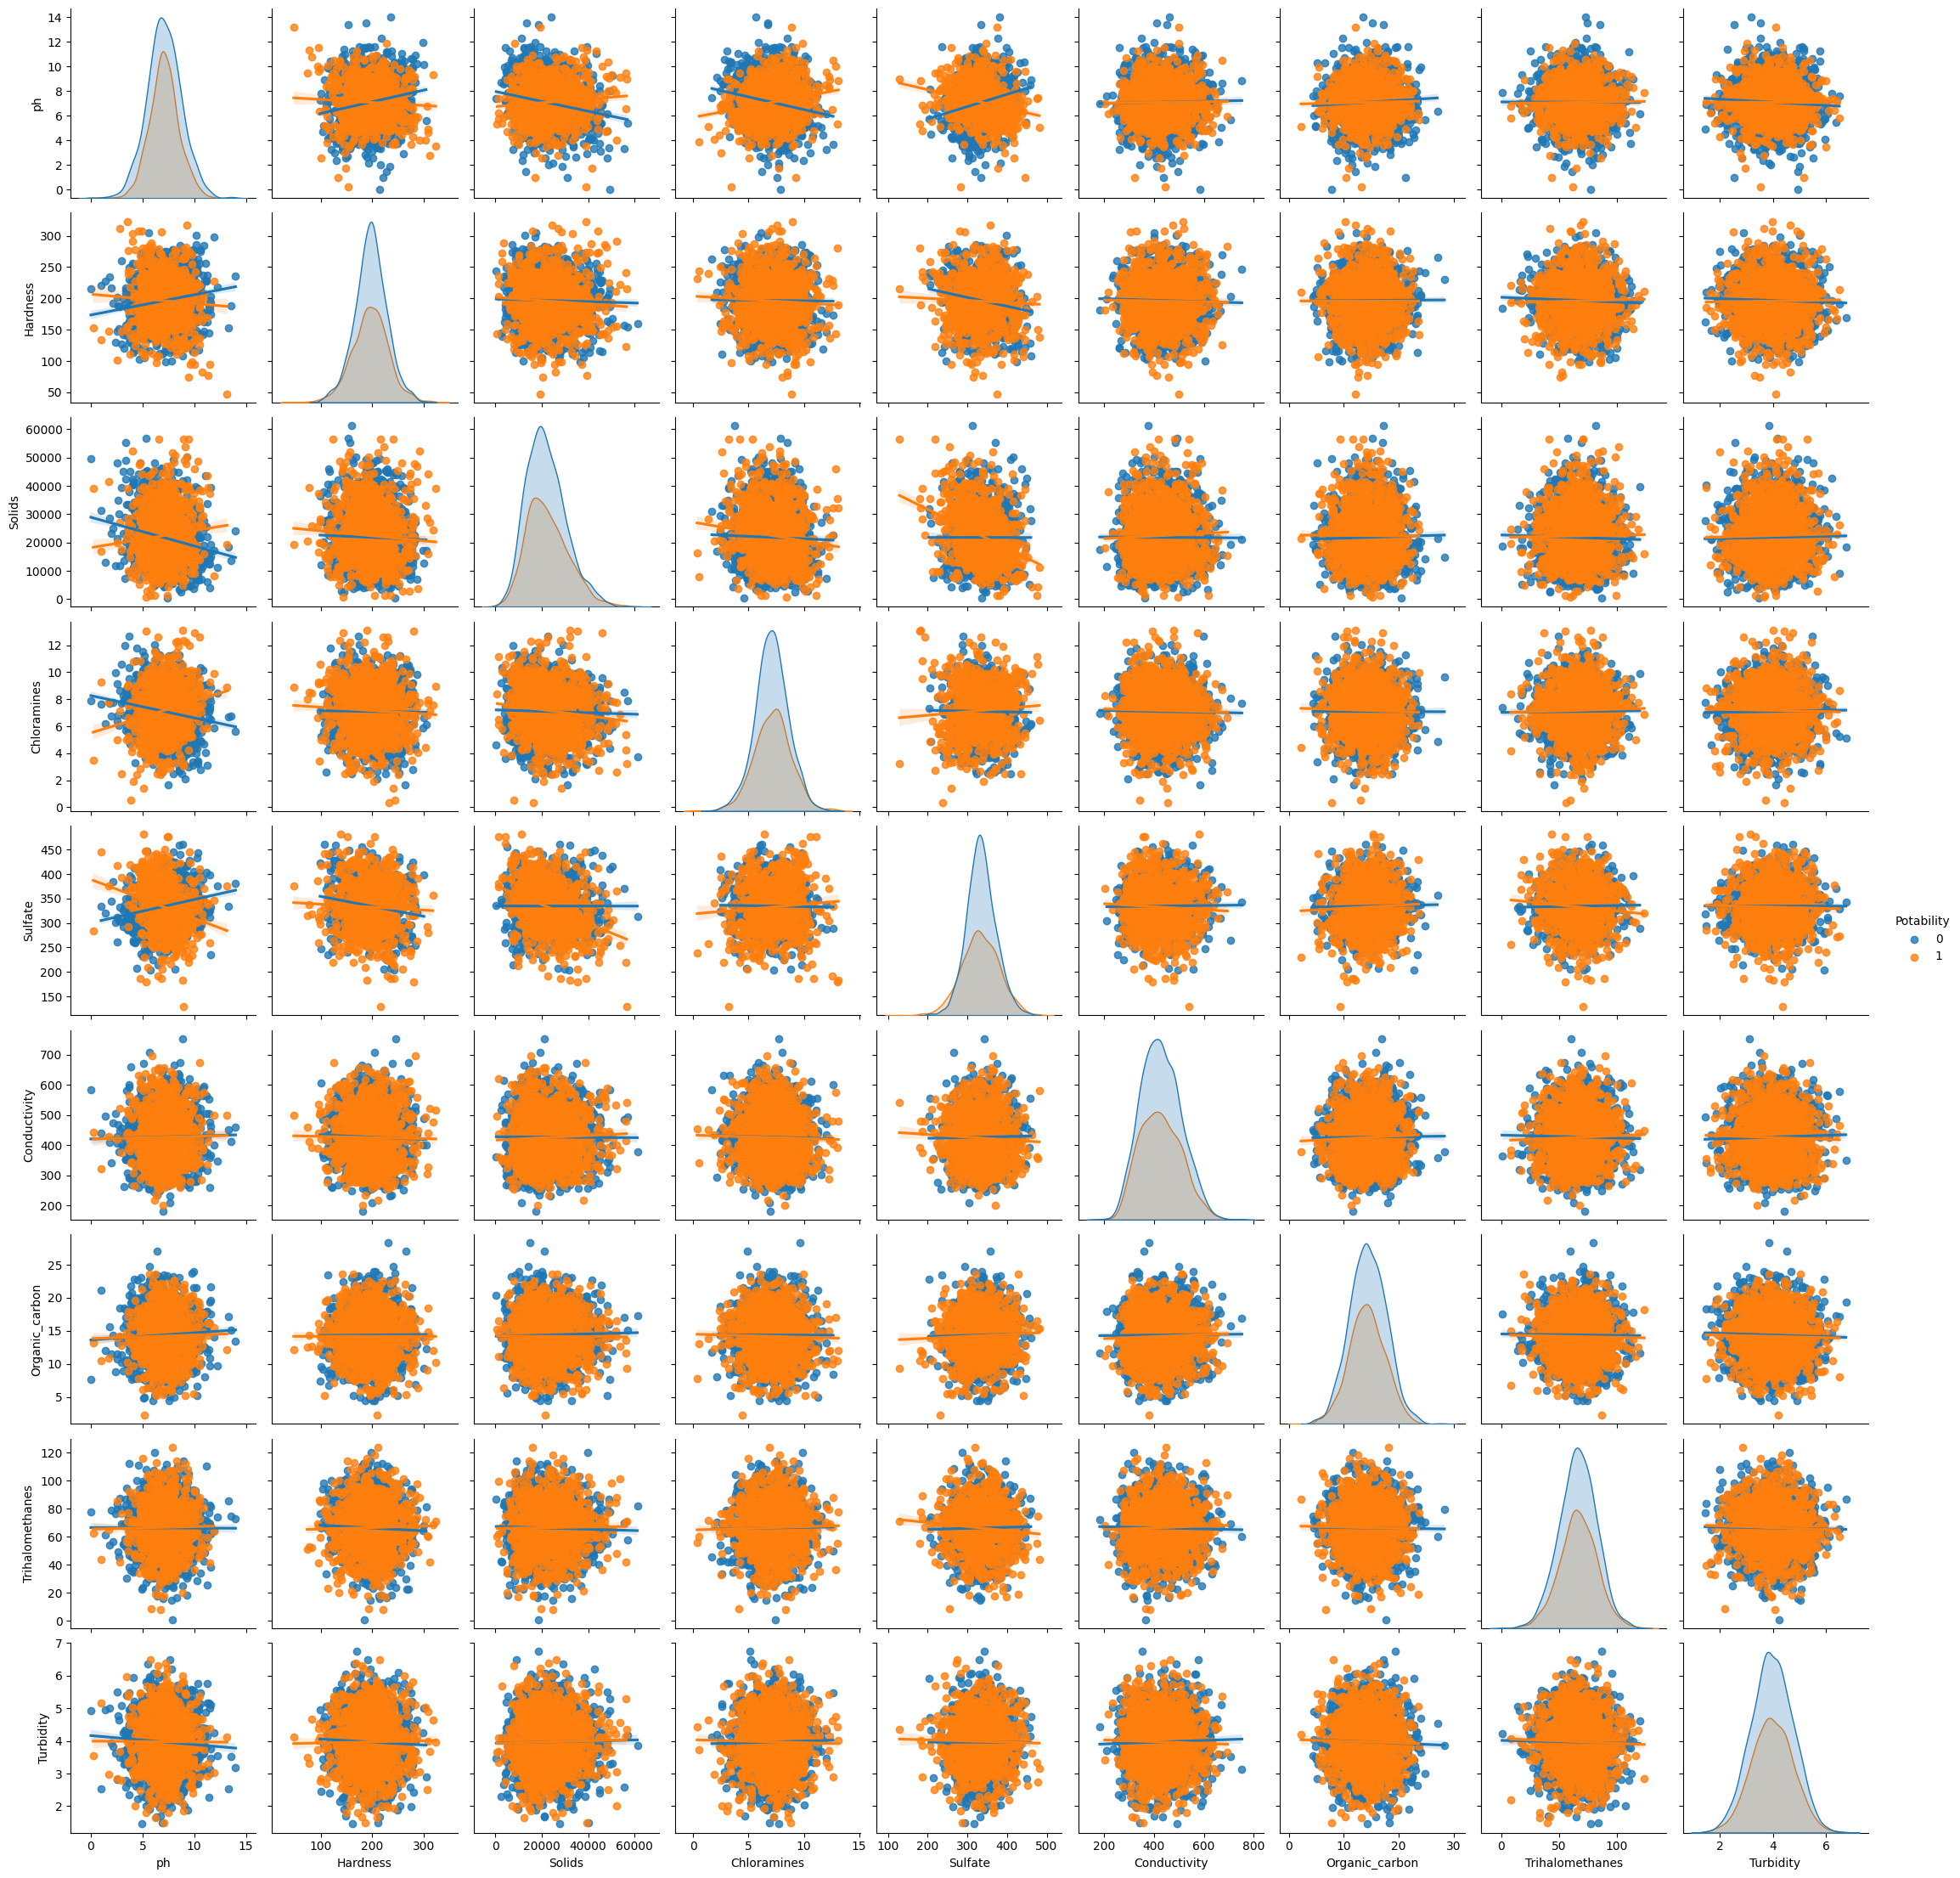

In [72]:
# Check distribution of numerical variables 
df_rawnum = df_raw.drop('Potability', axis = 1)
df_rawnum.hist(figsize=(12,8))

In [65]:
# check to see if data is normally distributed
df_rawnum.skew()


ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

The data skew is relatively low, and from now on will be considered as well-distributed in a normal manner.

<AxesSubplot:>

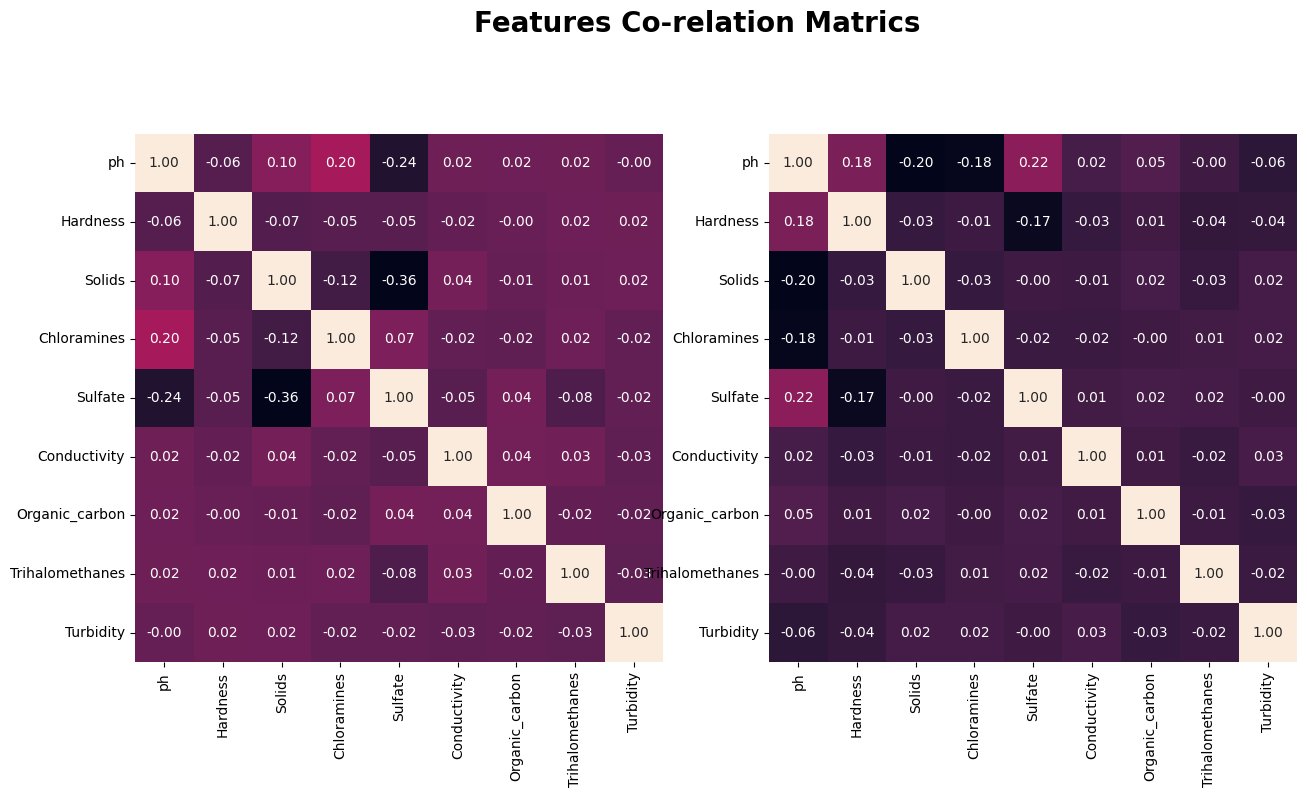

In [74]:
# check to see whether observations are independent 
#sns.pairplot(df_raw, hue='Potability', kind='reg')
fig, ax=plt.subplots(nrows=1, ncols=2, figsize=(15,8))
plt.suptitle("Features Co-relation Matrics", size=20, weight='bold')
ax=ax.flatten()
sns.heatmap(df_raw[df_raw['Potability']==1].corr(), annot=True, square=True, fmt='.2f', ax=ax[0], cbar=False)
sns.heatmap(df_raw[df_raw['Potability']==0].corr(), annot=True, square=True, fmt='.2f', ax=ax[1], cbar=False)


The features seem to be independent of each other. We therefore most likely cannot use linear models to classify water potability. 

# Missing Data Exploration 

<AxesSubplot:>

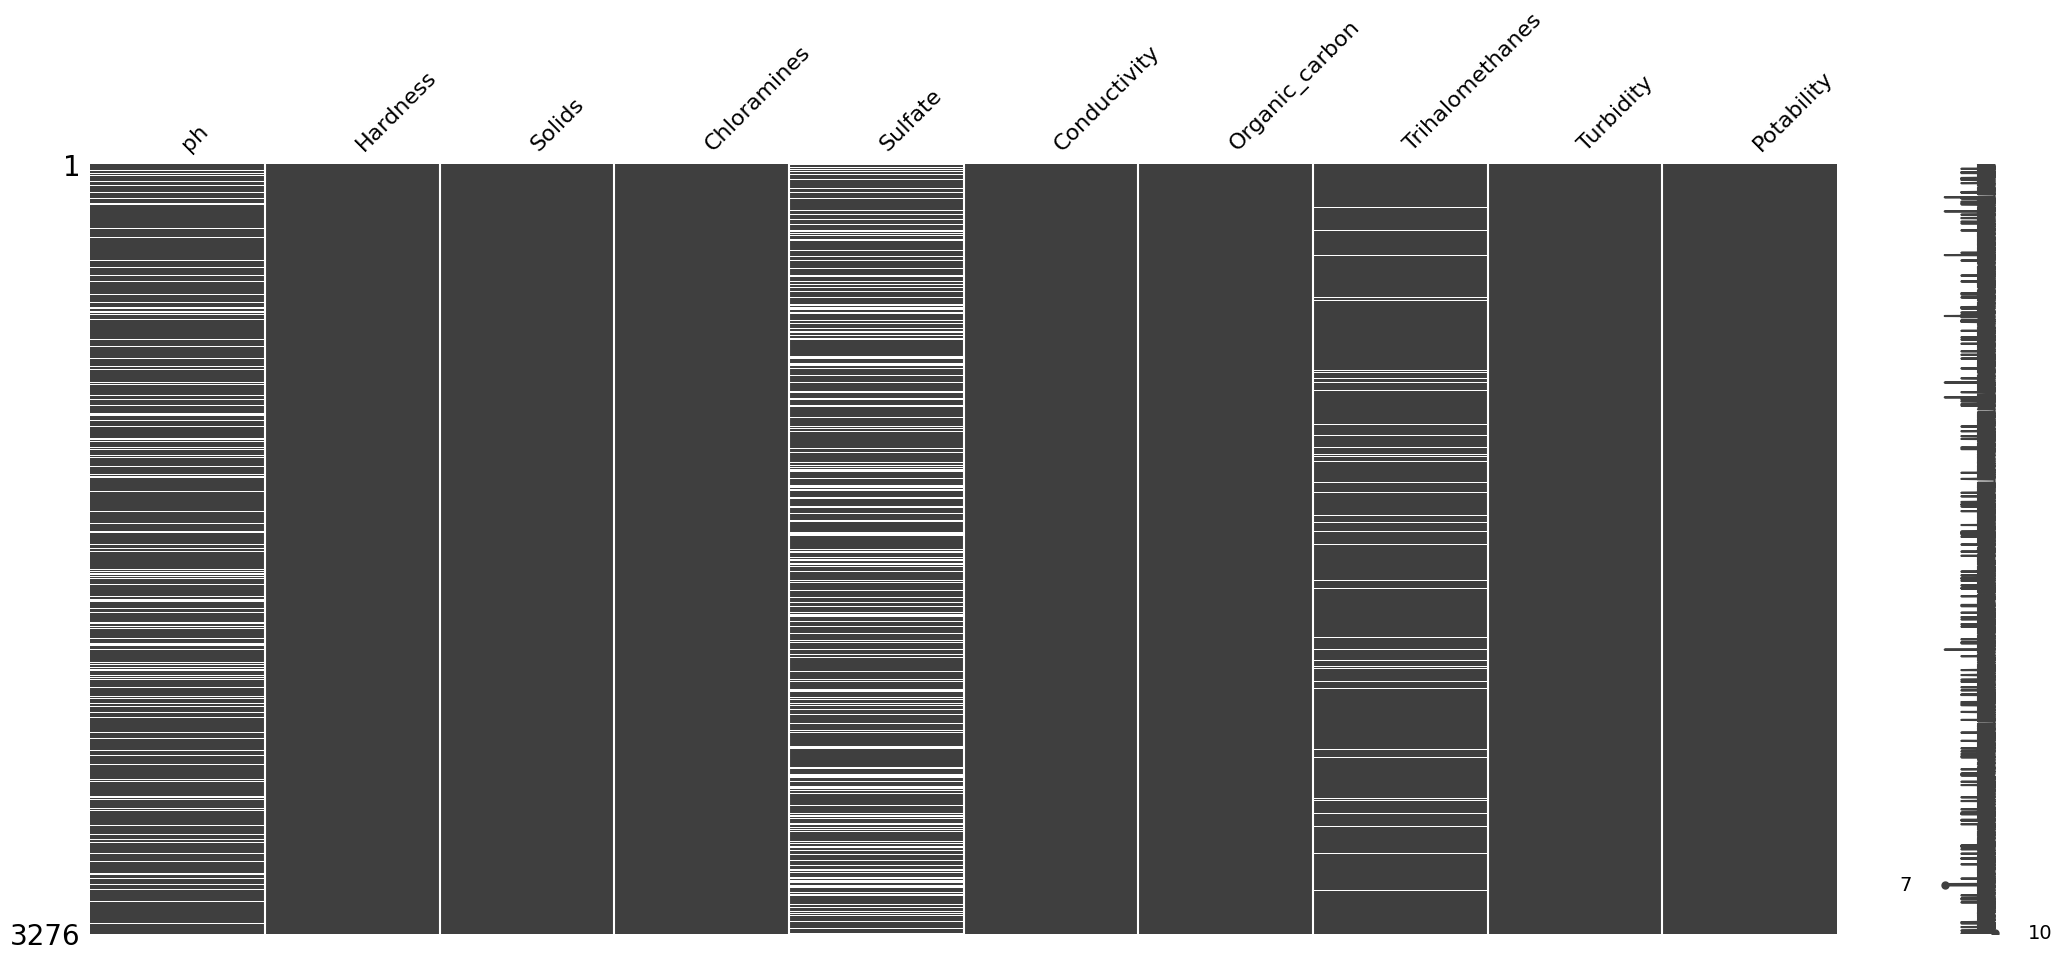

In [79]:
# check the missing data
df_raw.isnull().sum()
msno.matrix(df_raw)

<AxesSubplot:>

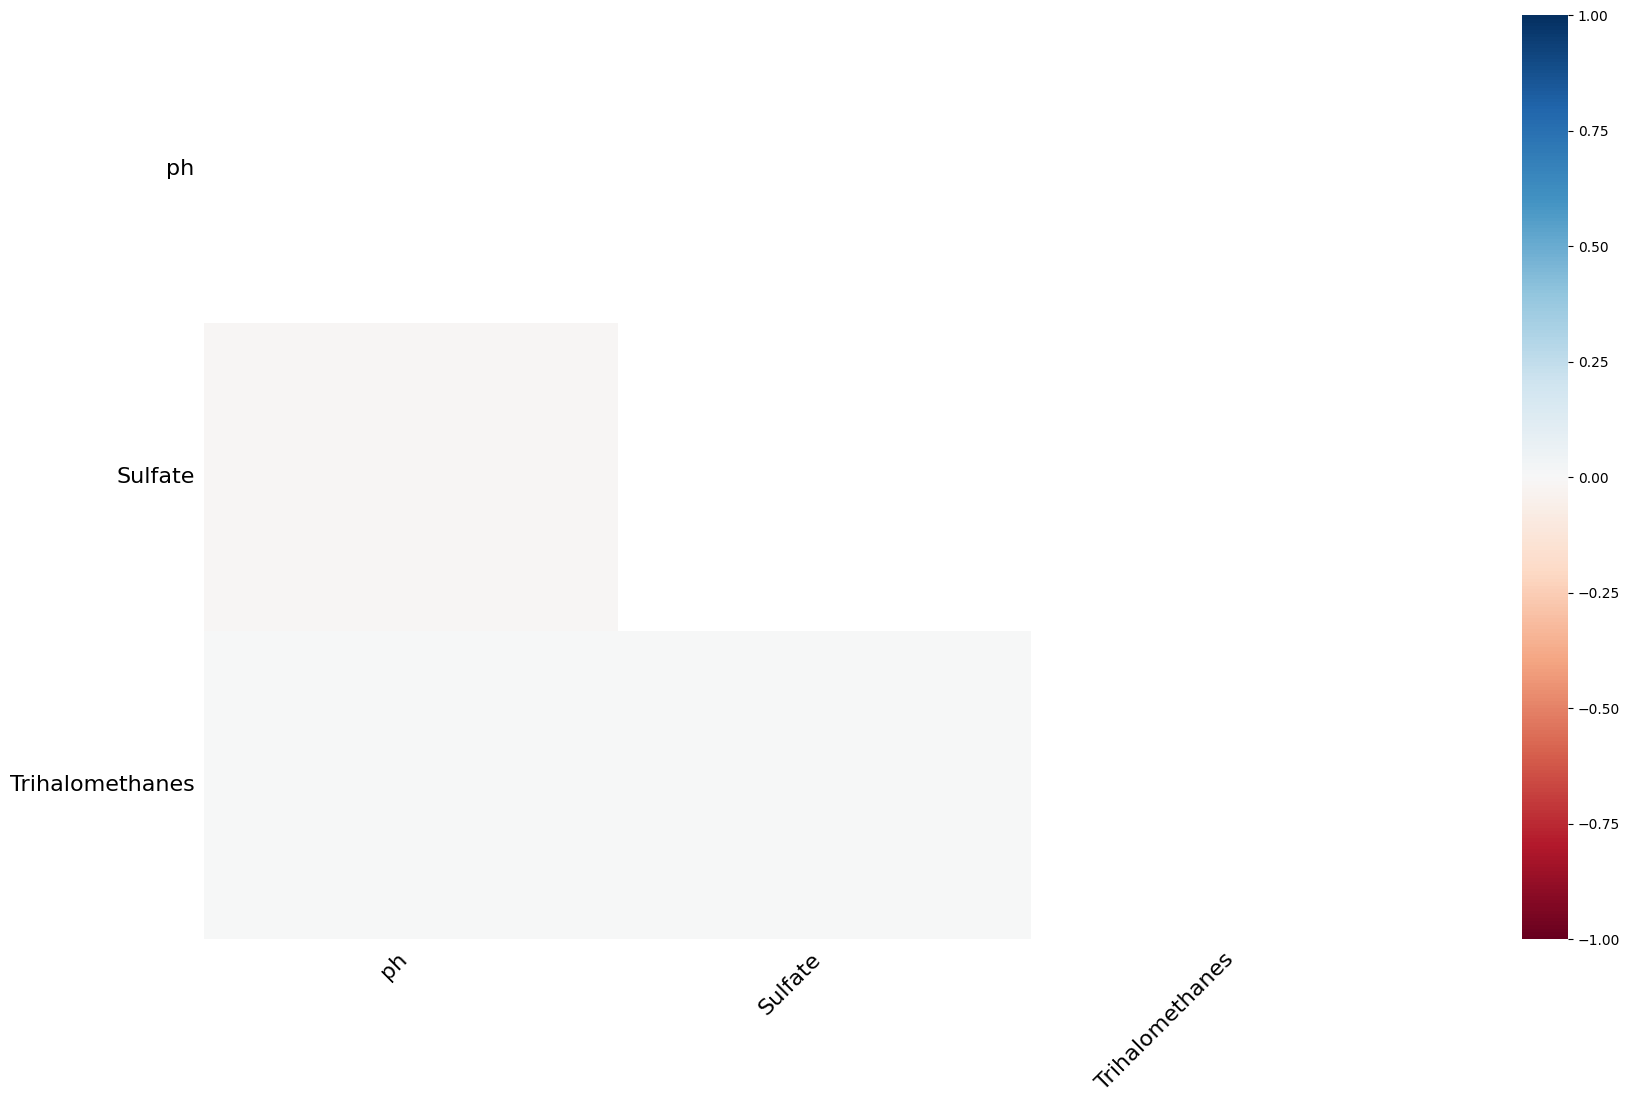

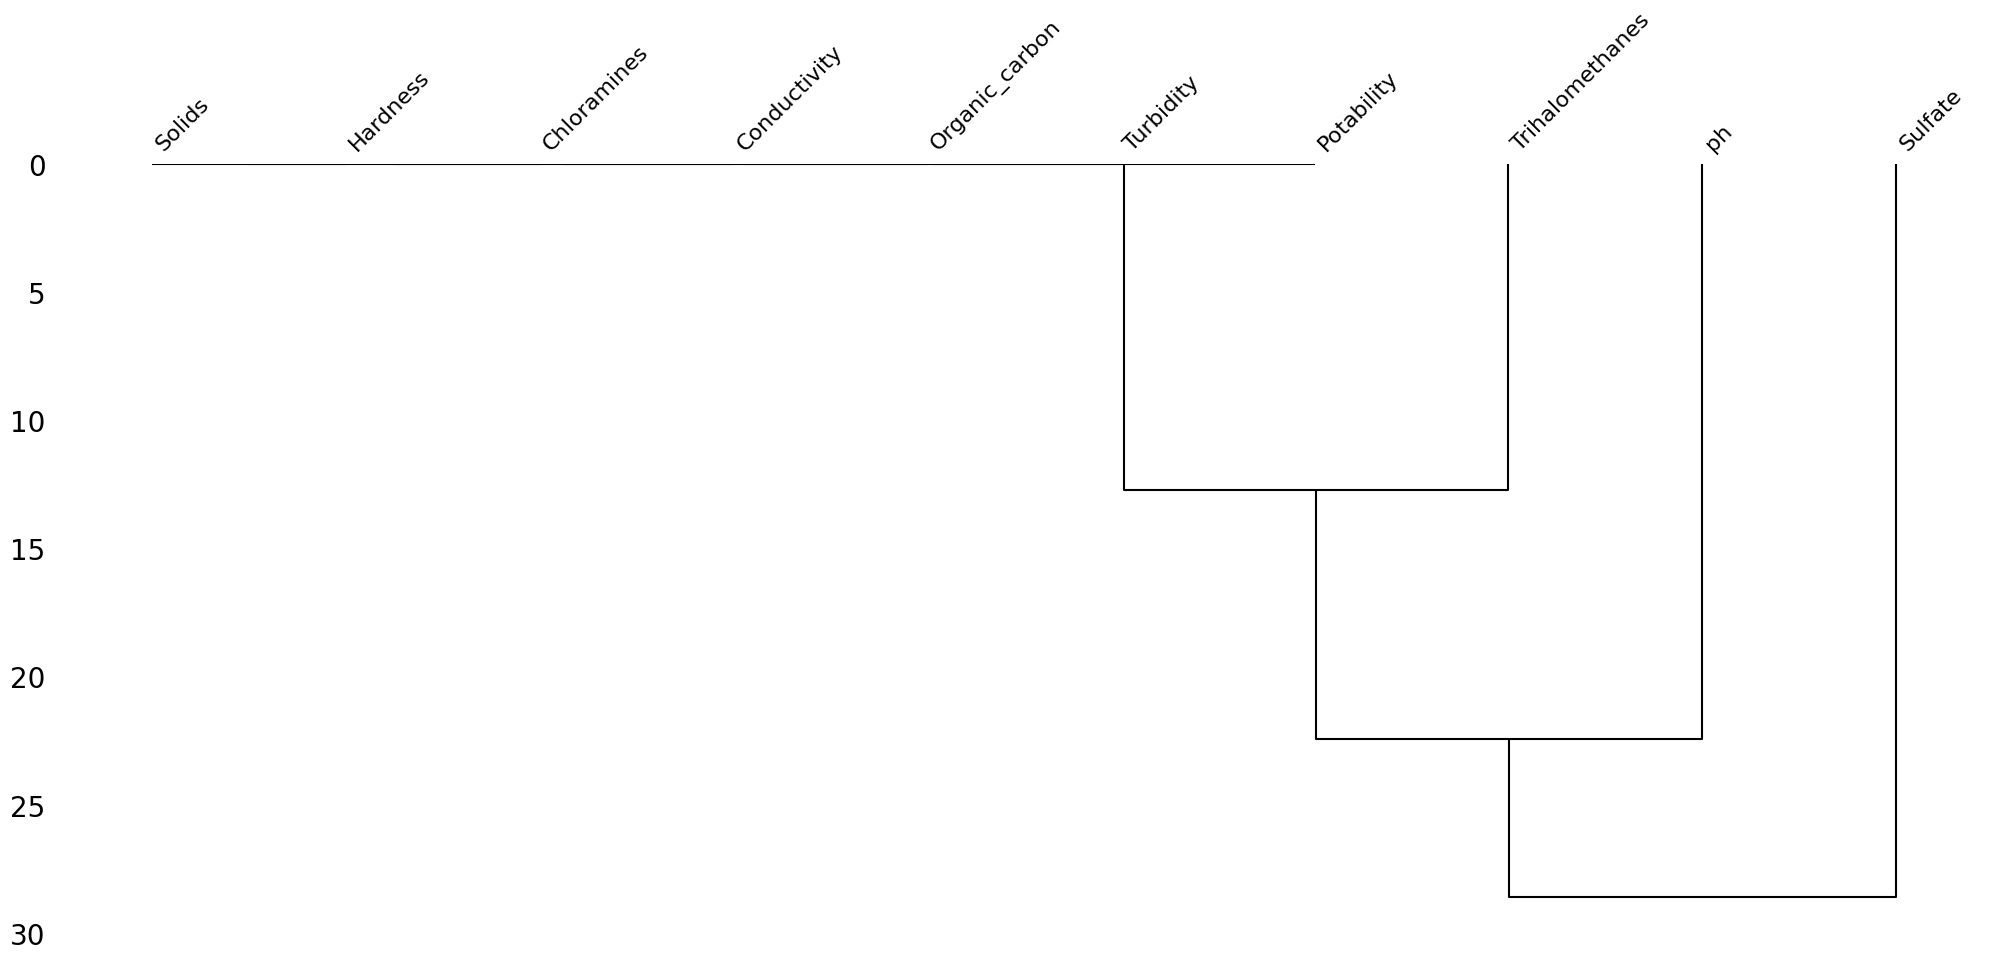

In [82]:
# see if missing data is correlated to any factor 
msno.heatmap(df_raw)
msno.dendrogram(df_raw)

Null values are quite randomly dispered and have no correlation to other data collected. 

In [ ]:
# Performing Mean-Median Imputation 
# First we have to check whether we need to impute missing values independently 


# Missing Data Imputation & XGBoost Implementation


In [84]:
# split data 
X = df_raw.drop('Potability', axis=1)
y = df_raw['Potability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1378)


In [87]:
X_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
2136,7.955026,244.395898,32405.413861,3.318045,307.643561,433.911804,16.254483,67.680774,3.955917
1769,9.663159,131.711896,24387.968071,4.234143,NaN,428.906432,18.143474,65.360465,5.270218
2802,5.230454,152.094169,24790.724599,6.308730,388.998079,307.918075,12.594197,51.625213,3.695615
1378,7.499844,210.985034,23707.465304,7.148518,NaN,484.843340,18.081957,52.967469,4.454477
768,10.538098,200.139829,13867.244196,7.365015,409.446730,340.808823,17.073123,72.730639,3.823093


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
count,1938.000000,2293.000000,2293.000000,2293.000000,1750.000000,2293.000000,2293.000000,2205.000000,2293.000000
mean,7.058604,196.122418,21991.004290,7.112490,333.946002,426.228828,14.248636,66.686195,3.965227
std,1.599523,32.990216,8851.621074,1.600463,42.130285,79.581849,3.317203,16.081799,0.774733
min,0.000000,47.432000,320.942611,0.352000,129.000000,201.619737,2.200000,0.738000,1.492207
25%,6.072972,176.413638,15719.493609,6.124095,308.447589,367.570082,12.079207,56.188852,3.442983
50%,7.008788,196.658947,20852.764496,7.112622,333.254132,422.067701,14.219532,66.814176,3.958543
75%,8.026741,216.381880,27141.362903,8.120631,360.365492,481.771934,16.501578,77.523430,4.492387
max,14.000000,323.124000,61227.196008,13.127000,481.030642,695.369528,28.300000,120.030077,6.494249


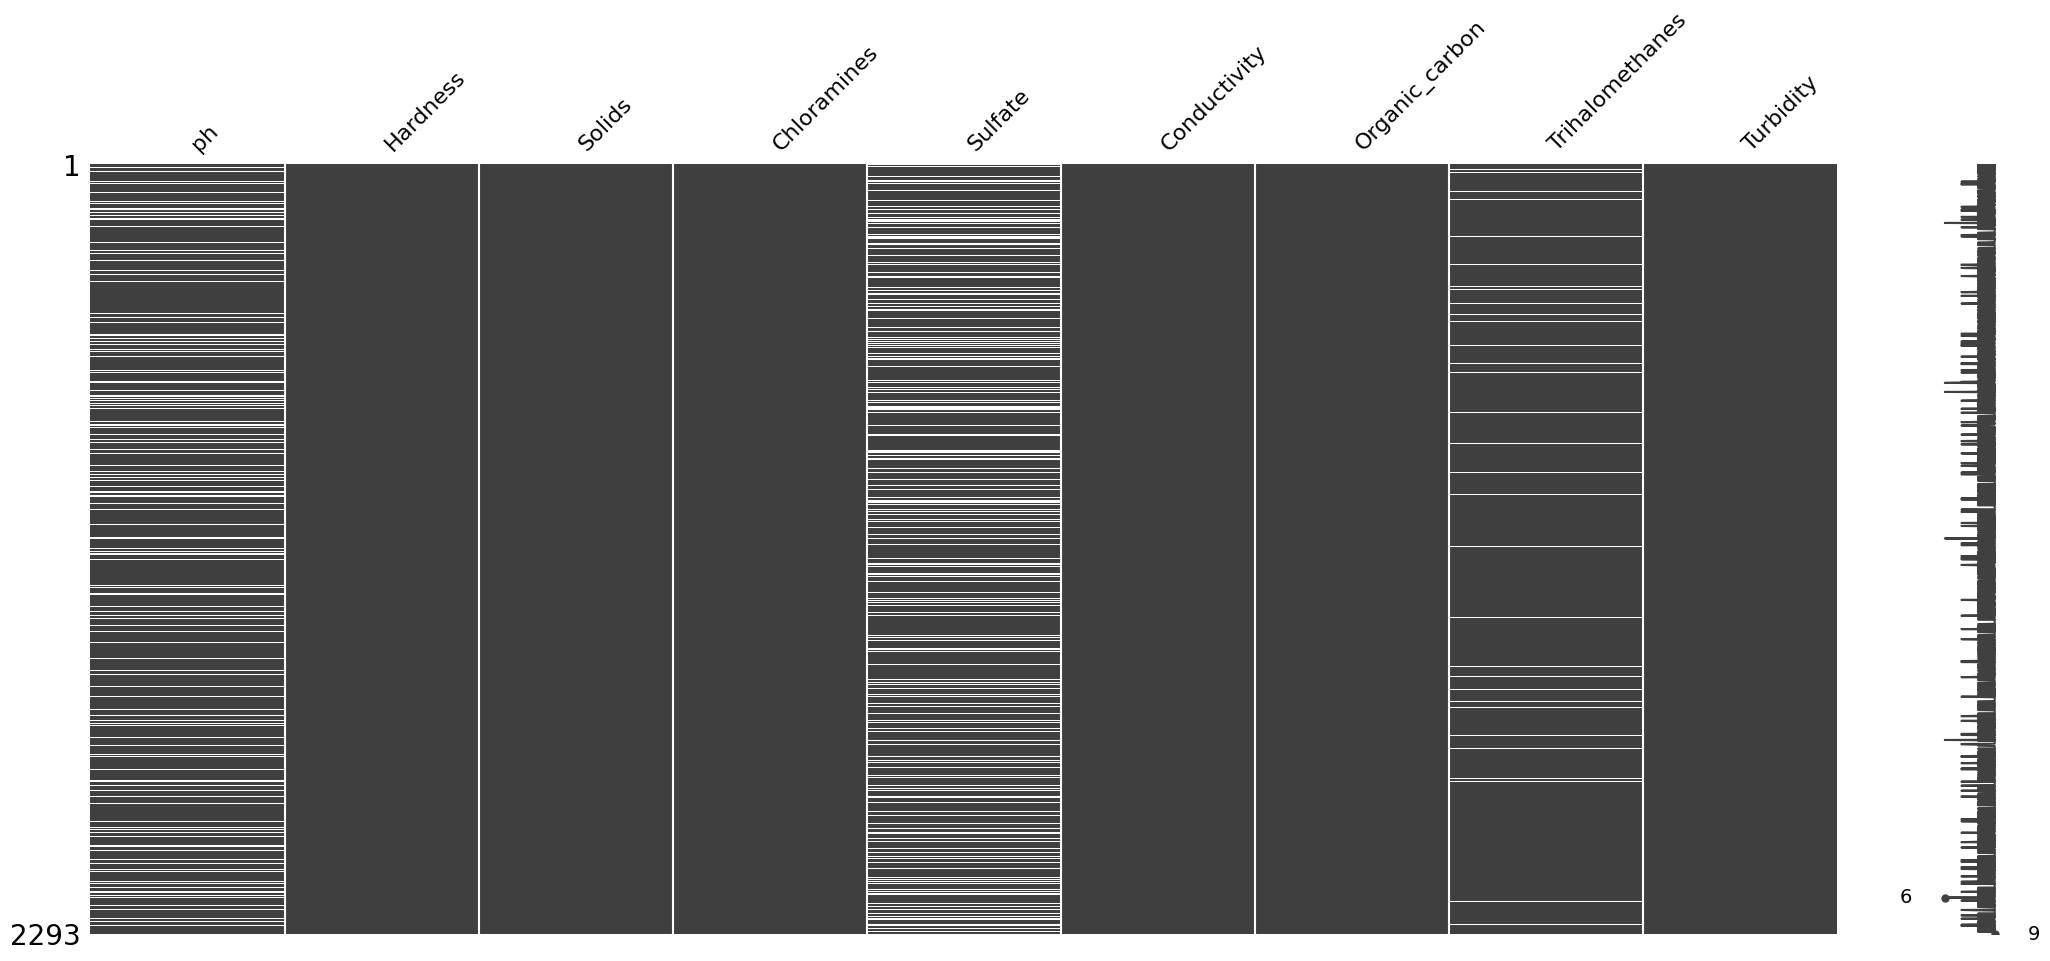

In [89]:
# check whether the training data has the same characterisitics as the full data
msno.matrix(X_train)
X_train.describe()

In [90]:
X_train.skew()

ph                 0.048387
Hardness          -0.018512
Solids             0.670928
Chloramines        0.007942
Sulfate           -0.097761
Conductivity       0.207326
Organic_carbon     0.000072
Trihalomethanes   -0.113584
Turbidity         -0.038057
dtype: float64

In [91]:
X_train.isnull().mean()*100

ph                 15.481901
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.680768
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     3.837767
Turbidity           0.000000
dtype: float64

In [92]:
# Use scikitlearn for simple imputation 
imputer = SimpleImputer(strategy='median') # median imputation ('mean' for mean and 'most_frequent' for mode imputations)
imputer.fit(X_train) # SimpleImputer() learns the median values from the train data
X_train = imputer.transform(X_train) # replace missing values with medians
X_test = imputer.transform(X_test) # replace missing values with medians


In [93]:
X_test=pd.DataFrame(X_test)
X_train= pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8
0,7.955026,244.395898,32405.413861,3.318045,307.643561,433.911804,16.254483,67.680774,3.955917
1,9.663159,131.711896,24387.968071,4.234143,333.254132,428.906432,18.143474,65.360465,5.270218
2,5.230454,152.094169,24790.724599,6.308730,388.998079,307.918075,12.594197,51.625213,3.695615
3,7.499844,210.985034,23707.465304,7.148518,333.254132,484.843340,18.081957,52.967469,4.454477
4,10.538098,200.139829,13867.244196,7.365015,409.446730,340.808823,17.073123,72.730639,3.823093


### Build the XGBoost Model (W/O CrossV)

In [117]:
# train model wihtout cross validation & check accuracy 
model = XGBClassifier(eval_metric='logloss')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f'Size of the X_train: {X_train.shape[0]}')


accuracy = accuracy_score(y_test, predictions)
print (f'Accuracy: {round(accuracy * 100.0,3)}')
print('Precision: %.3f' % precision_score(y_test, predictions))
print('Recall: %.3f' % recall_score(y_test, predictions))
print('F1 Score: %.3f' % f1_score(y_test, predictions))



Size of the X_train: 2293
Accuracy: 65.005
Precision: 0.572
Recall: 0.405
F1 Score: 0.474


# Accuracy: 65.005
# Precision: 0.572
# Recall: 0.405
# F1 Score: 0.474


Seems like the model is not performing too well with the XGBoost algorithm. 

Let's see if cross validation can help!



### Build the XGBoost Model (W/ CrossV)

In [97]:
# 100 repeated 5 fold cross validation 
cv    = RepeatedKFold(n_splits=5, n_repeats=100, random_state=101)
folds = [(train,test) for train, test in cv.split(X_train, y_train)]

# result collection
metrics = ['auc', 'fpr', 'tpr', 'thresholds']
results = {
    'train': {m:[] for m in metrics},
    'val'  : {m:[] for m in metrics},
    'test' : {m:[] for m in metrics}
}


In [106]:
# 10 Fold Cross Validation of XGBoost
params = {
    'objective'   : 'binary:logistic',
    'eval_metric' : 'logloss'
}

dtest = xgb.DMatrix(X_test, label=y_test)

# tqdm is a progress bar reporting function that iterates through the 100x5-fold cv
for train, test in tqdm(folds, total=len(folds)):
    dtrain = xgb.DMatrix(X_train.iloc[train,:], label=y_train.iloc[train])
    dval = xgb.DMatrix(X_train.iloc[test,:], label=y_train.iloc[test])
    model = xgb.train(
        dtrain = dtrain,
        params = params, 
        evals = [(dtrain, 'train'), (dval, 'val')],
        num_boost_round = 1000,
        verbose_eval = False,
        early_stopping_rounds = 10,
    )
    sets = [dtrain, dval, dtest]
    for i,ds in enumerate(results.keys()):
        y_preds = model.predict(sets[i])
        labels = sets[i].get_label()
        fpr, tpr, thresholds = roc_curve(labels, y_preds)
        results[ds]['fpr'].append(fpr)
        results[ds]['tpr'].append(tpr)
        results[ds]['thresholds'].append(thresholds)
        results[ds]['auc'].append(roc_auc_score(labels, y_preds))
        


  0%|          | 0/500 [00:00<?, ?it/s]

In [107]:
# PLOT ROC Curve
kind = 'val'
c_fill      = 'rgba(52, 152, 219, 0.2)'
c_line      = 'rgba(52, 152, 219, 0.5)'
c_line_main = 'rgba(41, 128, 185, 1.0)'
c_grid      = 'rgba(189, 195, 199, 0.5)'
c_annot     = 'rgba(149, 165, 166, 0.5)'
c_highlight = 'rgba(192, 57, 43, 1.0)'
fpr_mean    = np.linspace(0, 1, 100)
interp_tprs = []
for i in range(100):
    fpr           = results[kind]['fpr'][i]
    tpr           = results[kind]['tpr'][i]
    interp_tpr    = np.interp(fpr_mean, fpr, tpr)
    interp_tpr[0] = 0.0
    interp_tprs.append(interp_tpr)
tpr_mean     = np.mean(interp_tprs, axis=0)
tpr_mean[-1] = 1.0
tpr_std      = 2*np.std(interp_tprs, axis=0)
tpr_upper    = np.clip(tpr_mean+tpr_std, 0, 1)
tpr_lower    = tpr_mean-tpr_std
auc          = np.mean(results[kind]['auc'])
fig = go.Figure([
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_upper,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'upper'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_lower,
        fill       = 'tonexty',
        fillcolor  = c_fill,
        line       = dict(color=c_line, width=1),
        hoverinfo  = "skip",
        showlegend = False,
        name       = 'lower'),
    go.Scatter(
        x          = fpr_mean,
        y          = tpr_mean,
        line       = dict(color=c_line_main, width=2),
        hoverinfo  = "skip",
        showlegend = True,
        name       = f'AUC: {auc:.3f}')
])
fig.add_shape(
    type ='line', 
    line =dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.update_layout(
    template    = 'plotly_white', 
    title_x     = 0.5,
    xaxis_title = "1 - Specificity",
    yaxis_title = "Sensitivity",
    width       = 800,
    height      = 800,
    legend      = dict(
        yanchor="bottom", 
        xanchor="right", 
        x=0.95,
        y=0.01,
    )
)
fig.update_yaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    scaleanchor = "x", 
    scaleratio  = 1,
    linecolor   = 'black')
fig.update_xaxes(
    range       = [0, 1],
    gridcolor   = c_grid,
    constrain   = 'domain',
    linecolor   = 'black')